In [1]:
import numpy as np
import pandas as pd
from utils.DataUtils import DataUtils
from utils.GloveUtils import GloveUtils
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from datasets import Dataset
from transformers import TrainingArguments, Trainer, EvalPrediction
import torch
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load the test data

In [5]:
test_df = pd.read_csv("./data/alpha_vantage_test.csv")
ds_test = Dataset.from_pandas(test_df)

# Initialize custom util library
utils = DataUtils()

#### For GloVe + Neural Network models only
Preprocessing

In [6]:
test_df['clean_txt'] = utils.clean_data(test_df['text'], max_words=64)

In [7]:
GLOVE_PATH = "./data/glove.6B.100d.txt"
glove_utils = GloveUtils(GLOVE_PATH, max_dims=64)
glove_emb_layer = glove_utils.create_glove_emb_layer(trainable=False)
emb_ids = glove_utils.get_embedding_indices(test_df['clean_txt'])

Glove Embedding shape: (400000, 100)


In [8]:
print(f'CUDA: {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}')
torch.cuda.empty_cache()

CUDA: True
DEVICE: cuda:0


In [10]:
emb_ids = emb_ids.to(device)
labels = torch.Tensor(np.asarray(test_df['label'], dtype=np.uint8)).to(device)

In [11]:
# Load pretrained model and send it to GPU/CPU
MODEL_PATH = "./models/2048_final_ep_300"
vantage_model = torch.load(MODEL_PATH)
vantage_model = vantage_model.to(device)

# Evaluate
with torch.no_grad():
    y_pred = np.argmax(torch.Tensor.cpu(vantage_model(emb_ids)), axis=1)
    print(classification_report(torch.Tensor.cpu(labels), y_pred))

              precision    recall  f1-score   support

         0.0       0.34      0.11      0.16        94
         1.0       0.51      0.53      0.52      1089
         2.0       0.59      0.55      0.57      3004
         3.0       0.59      0.64      0.62      2492
         4.0       0.46      0.43      0.44       473

    accuracy                           0.57      7152
   macro avg       0.50      0.45      0.46      7152
weighted avg       0.57      0.57      0.57      7152


# Evaluate Transformer models

In [15]:
# Callback func for accuracy computation
def eval_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    report = classification_report(p.label_ids, preds)
    print(report)
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc}


# training arguments for transformer based models
eval_args = TrainingArguments(
    output_dir="./results",
    do_train=False,
    do_eval=True,
    per_device_eval_batch_size=16,
    logging_dir="./results/logs",
    logging_steps=10,
)

### BERT-cased

In [13]:
MODEL_PATH = "./models/bert-cased"
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")


def tokenize(datapoint):
    return tokenizer(datapoint['text'], padding='max_length', truncation=True)


tokenized_test_df = ds_test.map(tokenize, batched=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=5)


E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/7152 [00:00<?, ? examples/s]

In [8]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_test_df,
    compute_metrics=eval_metrics,
)

# Run evaluation
eval_result = trainer.evaluate()

# Print results
print(eval_result)

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


              precision    recall  f1-score   support

           0       0.75      0.78      0.76        94
           1       0.53      0.93      0.68      1089
           2       0.68      0.58      0.63      3004
           3       0.69      0.64      0.67      2492
           4       0.64      0.42      0.51       473

    accuracy                           0.65      7152
   macro avg       0.66      0.67      0.65      7152
weighted avg       0.66      0.65      0.64      7152

{'eval_loss': 1.9427458047866821, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.6461129753914989, 'eval_runtime': 84.8545, 'eval_samples_per_second': 84.285, 'eval_steps_per_second': 5.268}


### BERT-uncased

In [14]:
MODEL_PATH = "./models/old_bert_uncased"
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")


def tokenize(datapoint):
    return tokenizer(datapoint['text'], padding='max_length', truncation=True)


tokenized_test_df = ds_test.map(tokenize, batched=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=5)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_test_df,
    compute_metrics=eval_metrics,
)

# Run evaluation
eval_result = trainer.evaluate()

# Print results
print(eval_result)

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/7152 [00:00<?, ? examples/s]

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


              precision    recall  f1-score   support

           0       0.66      0.65      0.65        94
           1       0.52      0.92      0.66      1089
           2       0.68      0.57      0.62      3004
           3       0.70      0.63      0.66      2492
           4       0.58      0.47      0.52       473

    accuracy                           0.64      7152
   macro avg       0.63      0.65      0.62      7152
weighted avg       0.66      0.64      0.63      7152

{'eval_loss': 2.0469412803649902, 'eval_model_preparation_time': 0.0011, 'eval_accuracy': 0.6368847874720358, 'eval_runtime': 89.6717, 'eval_samples_per_second': 79.758, 'eval_steps_per_second': 4.985}


### DistilBERT

In [16]:
MODEL_PATH = "./models/distilbert"
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(datapoint):
    return tokenizer(datapoint['text'], padding='max_length', truncation=True)


tokenized_test_df = ds_test.map(tokenize, batched=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=5)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_test_df,
    compute_metrics=eval_metrics,
)

# Run evaluation
eval_result = trainer.evaluate()

# Print results
print(eval_result)

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/7152 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.85      0.12      0.21        94
           1       0.58      0.91      0.71      1089
           2       0.69      0.64      0.66      3004
           3       0.71      0.63      0.66      2492
           4       0.59      0.52      0.55       473

    accuracy                           0.66      7152
   macro avg       0.68      0.56      0.56      7152
weighted avg       0.67      0.66      0.66      7152

{'eval_loss': 1.055662989616394, 'eval_model_preparation_time': 0.0011, 'eval_accuracy': 0.660934004474273, 'eval_runtime': 60.4205, 'eval_samples_per_second': 118.371, 'eval_steps_per_second': 7.398}


### FinBERT

In [15]:
def condense_label(example):
    l = example['label']
    if l == 0 or l == 1:
        example['label'] = 0
    elif l == 2:
        example['label'] = 1
    elif l == 3 or l == 4:
        example['label'] = 2
    return example


ds_test_condensed = ds_test.map(condense_label)


Map:   0%|          | 0/7152 [00:00<?, ? examples/s]

In [16]:
MODEL_PATH = "./models/finbert"
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")


def tokenize(datapoint):
    return tokenizer(datapoint['text'], padding='max_length', truncation=True)


tokenized_test_df = ds_test_condensed.map(tokenize, batched=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=3)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=eval_args,
    eval_dataset=tokenized_test_df,
    compute_metrics=eval_metrics,
)

# Run evaluation
eval_result = trainer.evaluate()

# Print results
print(eval_result)

E:\Academics\NEU\DS5230 - USML\Assignments\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/7152 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

           0       0.56      0.93      0.70      1183
           1       0.67      0.60      0.63      3004
           2       0.82      0.69      0.75      2965

    accuracy                           0.69      7152
   macro avg       0.68      0.74      0.69      7152
weighted avg       0.71      0.69      0.69      7152

{'eval_loss': 1.710095763206482, 'eval_model_preparation_time': 0.0016, 'eval_accuracy': 0.6921140939597316, 'eval_runtime': 84.7536, 'eval_samples_per_second': 84.386, 'eval_steps_per_second': 5.274}


# Plot train and test loss for models

In [14]:
def plot_transformer_models(trainer_path: str, name: str, save=False):
    train_hist = []

    with open(trainer_path, 'r') as json_file:
        train_hist.append(json.load(json_file))
    epochs = train_hist[0]['log_history']
    df_dicts = []

    for e in epochs:
        if "loss" in e:
            df_dicts.append({"epoch": e["epoch"], "train_loss": e["loss"]})
        if "eval_loss" in e:
            df_dicts.append({"epoch": e["epoch"], "eval_loss": e["eval_loss"], "eval_accuracy": e["eval_accuracy"]})

    df = pd.DataFrame(df_dicts)
    df = df.melt(["epoch"])
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x='epoch', y='value', hue='variable', marker='o')

    plt.title(f'Training and Evaluation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    if save:
        plt.savefig(f"./models/{name}.png")
    plt.show()

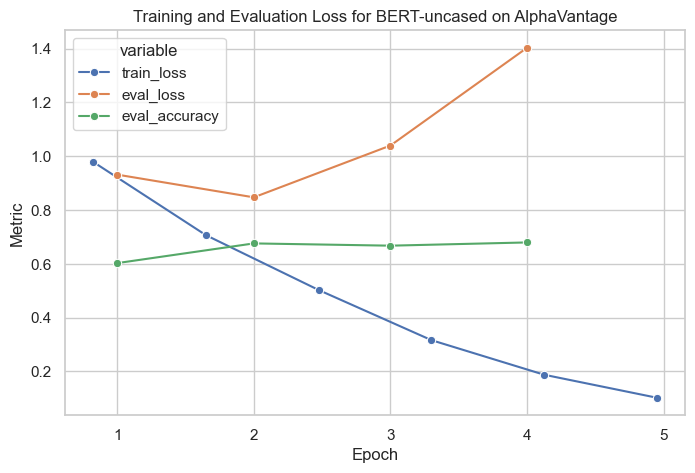

In [9]:
plot_transformer_models("./models/old_bert_uncased/trainer_state.json", "BERT-uncased on AlphaVantage", save=True)

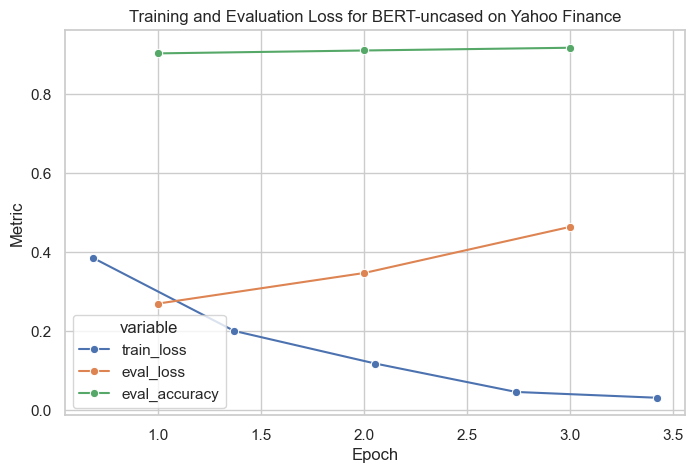

In [15]:
plot_transformer_models("./models/yahoo-bert-uncased/trainer_state.json", "BERT-uncased on Yahoo Finance", save=True)

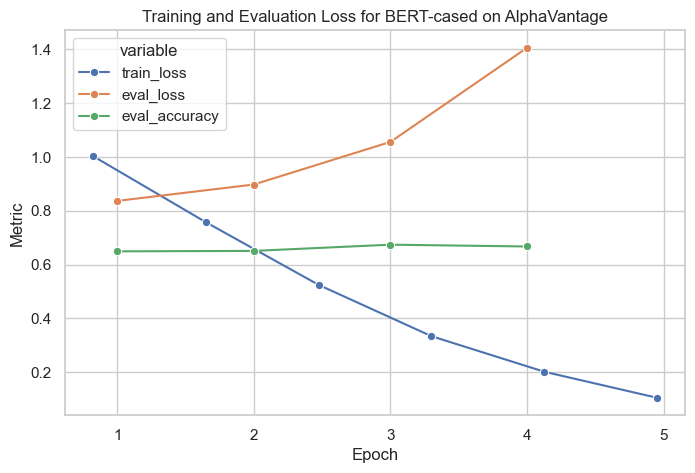

In [11]:
plot_transformer_models("./models/bert-cased/trainer_state.json", "BERT-cased on AlphaVantage")

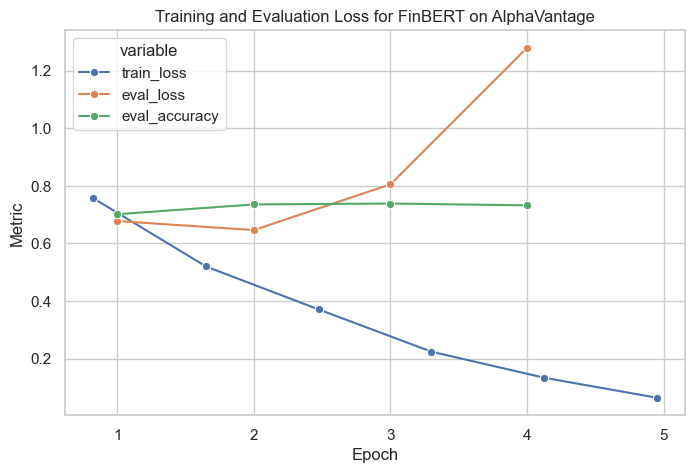

In [12]:
plot_transformer_models("./models/finbert/trainer_state.json", "FinBERT on AlphaVantage")

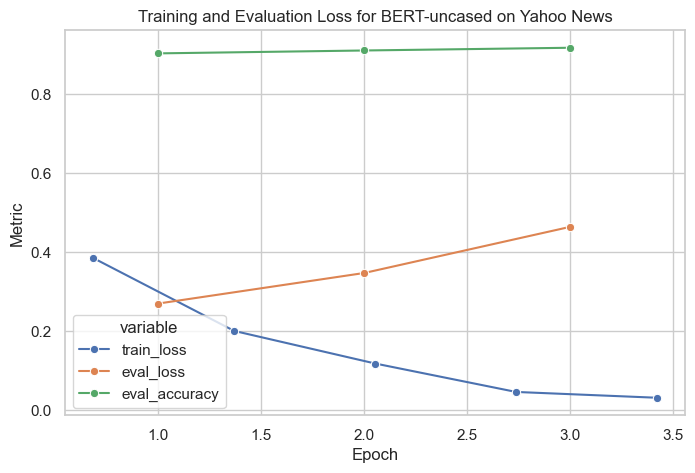

In [13]:
plot_transformer_models("./models/yahoo-bert-uncased/trainer_state.json", "BERT-uncased on Yahoo News", save=True)


In [81]:
def plot_glove_nn_models(csv_path: str, name: str, save=False):
    df = pd.read_csv(csv_path)
    df = df.melt(["epoch"])
    
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x='epoch', y='value', hue='variable', marker='o')

    plt.title(f'Training and Evaluation Loss for {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    if save:
        plt.savefig(f"./models/{name}.pdf")
    plt.show()

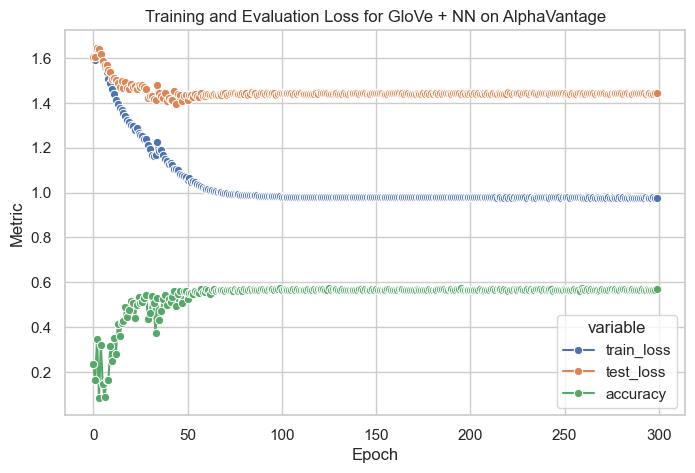

In [82]:
plot_glove_nn_models("./models/2048_final_ep_300_training_history.csv", "GloVe + NN on AlphaVantage", save=True)

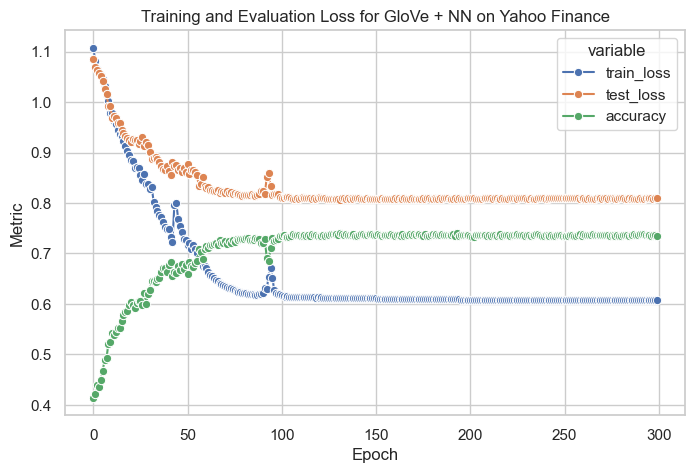

In [83]:
plot_glove_nn_models("./models/yahoo_2048_final_ep_300_training_history.csv", "GloVe + NN on Yahoo Finance", save=True)